In [1]:
import cv2
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from metrics import psnr, ssim
import tensorflow as tf

2024-01-08 23:14:29.862820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-08 23:14:29.862918: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-08 23:14:29.893919: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-08 23:14:29.959556: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-08 23:14:30.790109: W tensorflow/compiler/tf2

In [2]:
def create_unet_model():
    # encoder
    input = tf.keras.Input(shape=(48, 48, 3))
    conv1_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(input)
    conv1_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(conv1_1)
    maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv1_2)
    conv2_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(maxpool1)
    conv2_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(conv2_1)
    maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv2_2)
    conv3_1 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(maxpool2)
    conv3_2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(conv3_1)
    maxpool3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv3_2)
    conv4_1 = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(maxpool3)
    conv4_2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(conv4_1)

    #decoder
    up_conv1 = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=(2,2), strides=(2,2), padding='same')(conv4_2)
    up_conv1 = tf.keras.layers.Concatenate(axis=3)([up_conv1, conv3_2]) 
    conv5_1 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(up_conv1)
    conv5_2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(conv5_1)
    up_conv2 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2,2), strides=(2,2), padding='same')(conv5_2)
    up_conv2 = tf.keras.layers.Concatenate(axis=3)([up_conv2, conv2_2]) 
    conv6_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(up_conv2)
    conv6_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(conv6_1)
    up_conv3 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(2,2), strides=(2,2), padding='same')(conv6_1)
    up_conv3 = tf.keras.layers.Concatenate(axis=3)([up_conv3, conv1_2])
    conv7_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(up_conv3)
    conv7_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(conv7_1)
    up_conv4 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(2,2), strides=(2,2), padding='same')(conv7_2)
    conv8_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(up_conv4)
    conv8_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(conv8_1)
    output = tf.keras.layers.Conv2D(filters=3, kernel_size=(3, 3), activation='relu', padding='same')(conv8_2)

    model_unet = tf.keras.Model(inputs=input, outputs=output)
    return model_unet

Load data

In [3]:
input_folder = "./images"

image_files = [f for f in os.listdir(input_folder) if f.endswith(".png") or f.endswith(".jpg")]

images_Y = [cv2.imread(os.path.join(input_folder, img)) for img in image_files]

images_X = [cv2.resize(img, (48, 48), interpolation=cv2.INTER_AREA) for img in images_Y]

images_X = [img / 255.0 for img in images_X]
images_Y_ = [img / 255.0 for img in images_Y]

images_X = np.array(images_X)
images_Y = np.array(images_Y)

X_train, X_test, Y_train, Y_test = train_test_split(images_X, images_Y, test_size=0.2, random_state=42)

print(X_train.shape)
print(Y_train.shape)
print(type(X_train))

(4000, 48, 48, 3)
(4000, 96, 96, 3)
<class 'numpy.ndarray'>


In [4]:
model_unet = create_unet_model()
model_unet.summary()

2024-01-08 23:14:34.543517: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-08 23:14:34.677500: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 48, 48, 64)           36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [5]:
model_unet.compile(optimizer='adam', loss='mean_squared_error', metrics=[psnr, ssim])

In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [7]:
history = model_unet.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
50/50 [==============================] - 230s 5s/step - loss: 21247.9395 - psnr: -41.6026 - ssim: nan - val_loss: 7975.0654 - val_psnr: -38.6007 - val_ssim: 0.0029
Epoch 2/100
50/50 [==============================] - 226s 5s/step - loss: 4303.6577 - psnr: -35.7674 - ssim: 0.0232 - val_loss: 2555.1531 - val_psnr: -33.6761 - val_ssim: 0.0509
Epoch 3/100
50/50 [==============================] - 226s 5s/step - loss: 2114.3552 - psnr: -32.8645 - ssim: 0.0778 - val_loss: 1698.6481 - val_psnr: -31.8762 - val_ssim: 0.1130
Epoch 4/100
50/50 [==============================] - 227s 5s/step - loss: 1558.6846 - psnr: -31.5207 - ssim: 0.1442 - val_loss: 1450.5240 - val_psnr: -31.1820 - val_ssim: 0.1730
Epoch 5/100
50/50 [==============================] - 226s 5s/step - loss: 1260.5515 - psnr: -30.5590 - ssim: 0.2188 - val_loss: 1108.9486 - val_psnr: -29.9210 - val_ssim: 0.2660
Epoch 6/100
50/50 [==============================] - 226s 5s/step - loss: 970.1997 - psnr: -29.3171 - ssim: 0.33

In [8]:
model_unet.save('unet_model.h5')

/home/rol3ert99/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
model_unet.evaluate(X_test, Y_test)

32/32 [==============================] - 11s 352ms/step - loss: 150.6815 - psnr: -21.0400 - ssim: nan


[150.6815185546875, -21.039974212646484, nan]

In [10]:
metrics = pd.DataFrame(history.history)
metrics

,loss,psnr,ssim,val_loss,val_psnr,val_ssim
0,21247.939453,-41.602642,NaN,7975.065430,-38.600704,0.002892
1,4303.657715,-35.767429,0.023160,2555.153076,-33.676075,0.050912
2,2114.355225,-32.864464,0.077847,1698.648071,-31.876175,0.113042
3,1558.684570,-31.520672,0.144212,1450.524048,-31.182001,0.173043
4,1260.551514,-30.558969,0.218828,1108.948608,-29.920996,0.265952
...,...,...,...,...,...,...
95,152.857727,-21.048494,NaN,167.342133,-21.445478,-inf
96,149.585632,-20.942316,NaN,153.448608,-20.919456,-inf
97,145.898148,-20.803099,NaN,152.046082,-20.858562,NaN
98,145.025864,-20.768221,NaN,152.795639,-20.888727,NaN


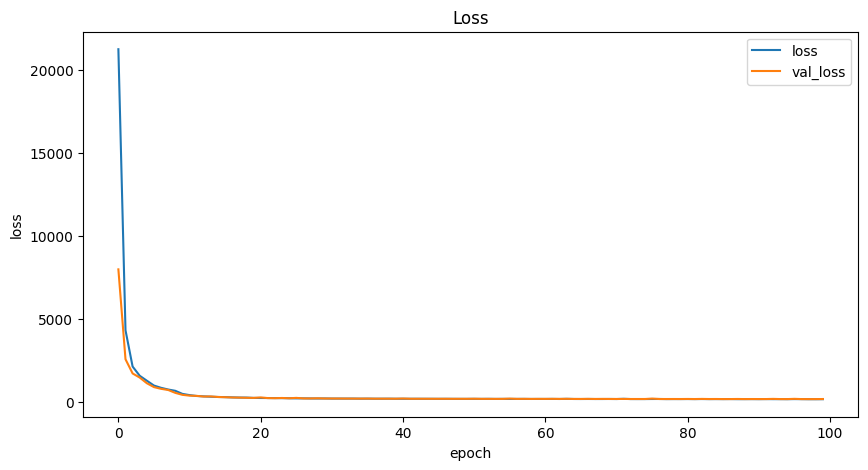

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(metrics['loss'], label='loss')
plt.plot(metrics['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

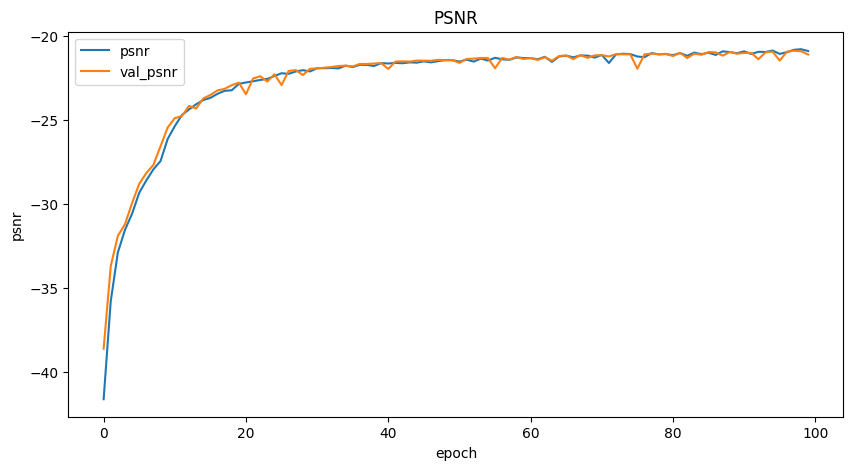

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(metrics['psnr'], label='psnr')
plt.plot(metrics['val_psnr'], label='val_psnr')
plt.title('PSNR')
plt.xlabel('epoch')
plt.ylabel('psnr')
plt.legend()
plt.show()

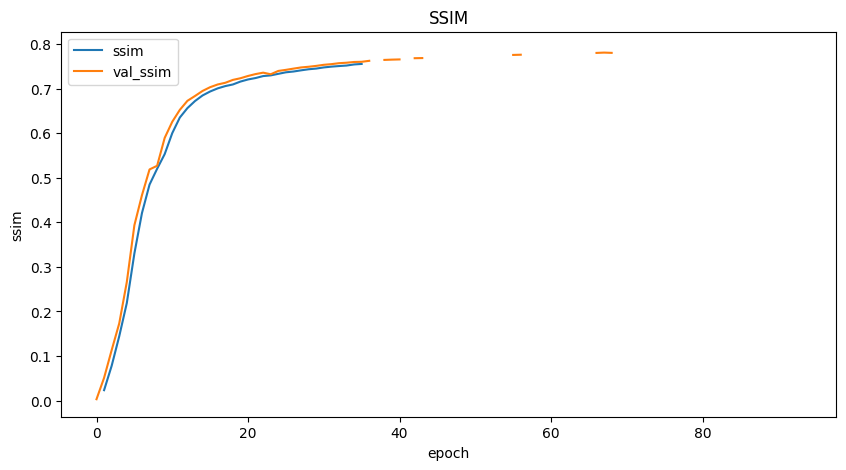

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(metrics['ssim'], label='ssim')
plt.plot(metrics['val_ssim'], label='val_ssim')
plt.title('SSIM')
plt.xlabel('epoch')
plt.ylabel('ssim')
plt.legend()
plt.show()

In [19]:
print(X_test.shape)
print(X_test[0].shape)

sample = np.reshape(X_test[0], (1, X_test[0].shape[0], X_test[0].shape[1], X_test[0].shape[2]))
print(sample.shape)

predicted_image = model_unet.predict(sample)

(1000, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
1/1 [==============================] - 0s 108ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Predicted')

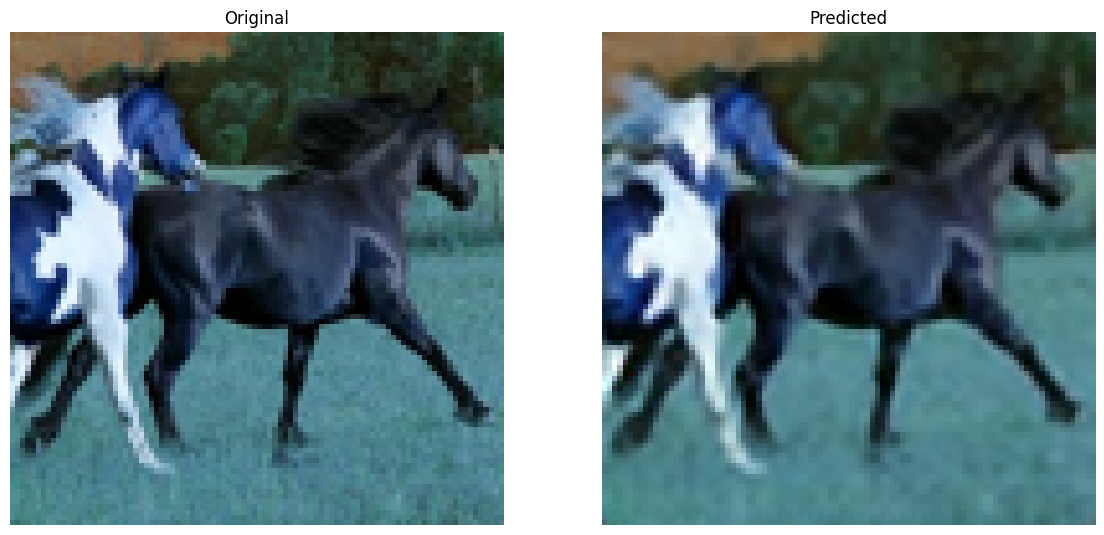

In [37]:
plt.figure(figsize=(14,14))
plt.subplot(1, 2, 1)
plt.imshow(Y_test[0] / 255.0)
plt.axis('off')
plt.title('Original')

plt.subplot(1, 2, 2)
predicted_image = np.reshape(predicted_image, (96, 96, 3))
plt.imshow(predicted_image / 255.0)
plt.axis('off')
plt.title('Predicted')